In [1]:
import pandas as pd
import gpxpy.geo as geo
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier 
import xgboost as xgb
from sklearn.metrics import roc_curve, auc,confusion_matrix,accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import pairwise_distances
import folium
from sklearn.utils import resample

# Import Data

In [2]:
#nbrs=pd.read_csv('existing_nbrs_3g - 107.csv')
nbrs=pd.read_csv('filtered.csv')# hand filtered nbrs
nw=pd.read_csv('nw_3g -active.csv')

In [84]:
nw.head()

site  cell   latitude  longitude  azimuth
0  1507     1  24.730818   46.76225        0
1  1507     2  24.730818   46.76225      140
2  1507     3  24.730818   46.76225      240
3  1604     1  25.145750   47.55302       70
4  1604     2  25.145750   47.55302      170

In [3]:
nbrs.columns=[x.lower() for x in list(nbrs.columns)]
nbrs.drop_duplicates(inplace=True)
nbrs.dropna(inplace=True)
nw.columns=[x.lower() for x in list(nw.columns)]
nw=nw[['site','cell','latitude','longitude','azimuth']]
nw.drop_duplicates(inplace=True)
nw.dropna(inplace=True)

# Add Source and Target Info

In [4]:
src_info_added=nbrs.merge(nw,how='inner',left_on=['sourcesite','sourcecell'],right_on=['site','cell'])
tgt_info_added=src_info_added.merge(nw,how='inner',left_on=['targetsite','targetcell'],right_on=['site','cell'])
tgt_info_added['distance']= tgt_info_added.apply(lambda row:
                                           geo.haversine_distance(row['latitude_x'],row['longitude_x'],row['latitude_y'],row['longitude_y']),axis=1)


In [5]:
tgt_info_added['distance'].to_csv('d.csv')

<IPython.core.display.Javascript object>


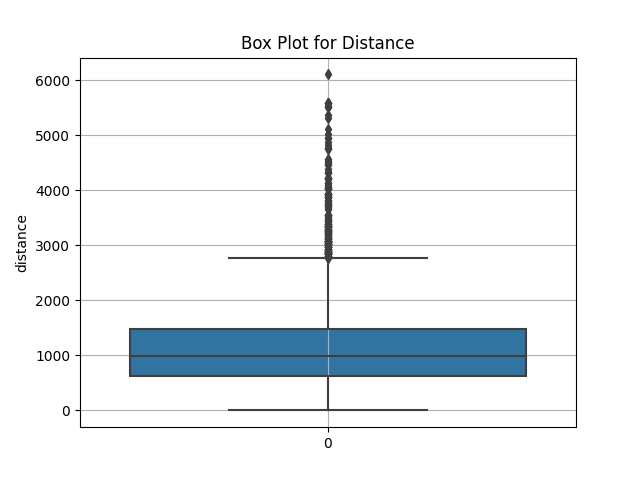

In [6]:
sns.boxplot(data =tgt_info_added['distance'])
plt.title("Box Plot for Distance")
plt.ylabel('distance')
plt.grid()
plt.show()


In [7]:
nbrs_filtered=tgt_info_added[tgt_info_added['distance']<=3000]
nbrs_filtered.drop(['site_x','cell_x','site_y','cell_y'],axis=1,inplace=True)
nbrs_filtered['y']=1

In [8]:
known_nw=pd.merge(nw,nbrs_filtered,how="inner",left_on=["site","cell"],right_on=["sourcesite","sourcecell"])

In [9]:
known_nw=known_nw[list(known_nw.columns[:5])]
known_nw.drop_duplicates(inplace=True)
known_nw.shape

(175, 5)

In [14]:
nbr_space=known_nw.merge(known_nw,how='cross')
nbr_space['distance']=nbr_space.apply(lambda row:
                                        geo.haversine_distance(row['latitude_x'],row['longitude_x'],row['latitude_y'],row['longitude_y']),axis=1)
nbr_space=nbr_space[(nbr_space['distance']>=0) & (nbr_space['distance']<3000) ]


In [15]:
nbrs_filtered.shape

(4153, 12)

In [16]:
nbr_space.shape

(12025, 11)

In [17]:
 ## all possible nbrs exist in it , our task is to add y column = 1 if nbr is exists else zero

In [18]:
D_total=nbr_space.merge(nbrs_filtered,how='left',left_on=['site_x','cell_x','site_y','cell_y'],right_on=['sourcesite','sourcecell','targetsite','targetcell'])

In [19]:
D_total.drop(['sourcesite', 'sourcecell', 'targetsite', 'targetcell',
       'latitude_x_y', 'longitude_x_y', 'azimuth_x_y', 'latitude_y_y',
       'longitude_y_y', 'azimuth_y_y', 'distance_y'],axis=1 ,inplace=True)

In [20]:
D_total.columns

Index(['site_x', 'cell_x', 'latitude_x_x', 'longitude_x_x', 'azimuth_x_x',
       'site_y', 'cell_y', 'latitude_y_x', 'longitude_y_x', 'azimuth_y_x',
       'distance_x', 'y'],
      dtype='object')

In [15]:
D_total.columns=['site_x', 'cell_x','lat1','long1', 'azi1','site_y', 'cell_y','lat2','long2','azi2','dist','y']

In [32]:
D_total['y'].fillna(0,inplace=True)

In [62]:
D_total.to_csv('for graphs.csv')

In [46]:
D_total.y.value_counts()

0.0    9821
1.0    2204
Name: y, dtype: int64

<IPython.core.display.Javascript object>


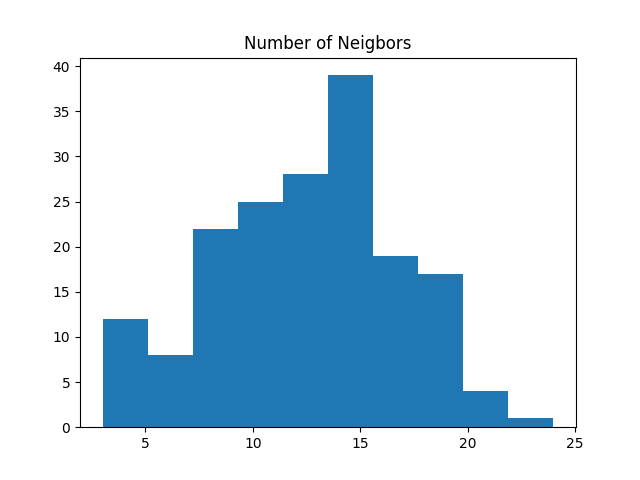

In [69]:
for_count=D_total[['site_x','cell_x','y']].groupby(by=['site_x','cell_x']).sum()
plt.hist(for_count.y,bins=10)
plt.title("Number of Neigbors")
plt.show()


In [61]:
labels = '0', '1'
sizes = [9821 ,2204]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Number of Samples For Each Class")
plt.show()

TypeError: set() argument after ** must be a mapping, not list

In [18]:
D_total[D_total['dist']==0]['y'].value_counts()

1.0    431
Name: y, dtype: int64

In [19]:
D_total.y.value_counts()

0.0    9647
1.0    2378
Name: y, dtype: int64

In [42]:
def show_nw(nw,long,lat):
    m = folium.Map(location=[lat,long],zoom_start=15,tiles=None)
    length = .002 
    for i,row in nw.iterrows():
        angle = row.azimuth
        tootip = str(row.site)+"_"+str(row.cell)
        origin_point = [row.latitude, row.longitude]
        end_lat = origin_point[0] + length * math.cos(math.radians(angle))
        end_lon = origin_point[1] + length * math.sin(math.radians(angle))
        folium.PolyLine([origin_point, [end_lat, end_lon]],color="#000000").add_to(m)
    return m

In [51]:
def show_cell(lat,long,azi,nbrs,non_nbrs):
    m = show_nw(nw,long,lat)
    folium.Marker([lat, long]).add_to(m)
    origin_point = [lat, long]
    length = .003
    angle = azi
    end_lat = origin_point[0] + length * math.cos(math.radians(angle))
    end_lon = origin_point[1] + length * math.sin(math.radians(angle))
    folium.PolyLine([origin_point, [end_lat, end_lon]],weight=10,color="green").add_to(m)
    for i,row in nbrs.iterrows():
        angle=row.azi2
        origin_point = [row.lat2, row.long2]
        end_lat = origin_point[0] + length * math.cos(math.radians(angle))
        end_lon = origin_point[1] + length * math.sin(math.radians(angle))
        folium.PolyLine([origin_point, [end_lat, end_lon]],weight=2.5,color="#FFFF00").add_to(m)
    ''' for i,row in non_nbrs.iterrows():
        angle=row.azi2
        origin_point = [row.lat2, row.long2]
        end_lat = origin_point[0] + length * math.cos(math.radians(angle))
        end_lon = origin_point[1] + length * math.sin(math.radians(angle))
        folium.PolyLine([origin_point, [end_lat, end_lon]],weight=2.5,color="red").add_to(m)'''
    return m

In [52]:
D_total.head()

site_x  cell_x       lat1      long1  azi1  site_y  cell_y       lat2  \
0    1114       1  24.692417  46.672787    20    1114       1  24.692417   
1    1114       1  24.692417  46.672787    20    1215       1  24.686503   
2    1114       1  24.692417  46.672787    20    1215       2  24.686503   
3    1114       1  24.692417  46.672787    20    1215       3  24.686503   
4    1114       1  24.692417  46.672787    20     620       2  24.668877   

       long2  azi2         dist    y  
0  46.672787    20     0.000000  1.0  
1  46.649392   350  2456.121910  0.0  
2  46.649392   130  2456.121910  0.0  
3  46.649392   250  2456.121910  0.0  
4  46.674178   150  2624.235396  0.0

In [35]:
## All co located should be nbrs
D_total.loc[D_total['dist']==0,'y']=1

KeyError: 'dist'

In [53]:
def display_cell(site,cell):
    nbrs=D_total[(D_total['site_x']==site) & (D_total['cell_x']==cell) & (D_total['y']==1)]
    non_nbrs=D_total[(D_total['site_x']==site) & (D_total['cell_x']==cell) & (D_total['y']==0)]
    curr=known_nw[(known_nw['site']==site) & (known_nw['cell']==cell)]
    return show_cell(curr.latitude.item(),curr.longitude.item(),curr.azimuth.item(),nbrs,non_nbrs)

In [59]:
display_cell(4880,2)

ValueError: can only convert an array of size 1 to a Python scalar

In [ ]:
m=[]
for i,row in tqdm(known_nw.iterrows()):
    site=row['site']
    cell=row['cell']
    print(site,cell)
    display(display_cell(site,cell))

0it [00:00, ?it/s]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



# EDA and Feature creations

1) Nbr Count

In [25]:
result=[]
for i in range (D_total.shape[0]):
    curr=D_total.iloc[i,:3]
    nbrs=D_total[(D_total['lat1']==curr[0]) & (D_total['long1']==curr[1]) & (D_total['azi1']==curr[2]) & (D_total['y']==1)]
    #non_nbrs=D_total[(D_total['lat1']==random_cell[0]) & (D_total['long1']==random_cell[1]) & (D_total['azi1']==random_cell[2]) & (D_total['y']==0)]
    result.append(np.mean(nbrs['dist']))

In [73]:
def angleFromCoordinate(lat1,lon1,lat2,lon2):   
    ''' Calculates angle between two points given lat/long'''
    return ((math.atan2(lon2 - lon1, lat2 - lat1)*180/math.pi)+360)%360

In [89]:
D_total=nbr_space.merge(nbrs_filtered,how='left',left_on=['site_x','cell_x','site_y','cell_y'],right_on=['sourcesite','sourcecell','targetsite','targetcell'])
D_total.drop(['sourcesite', 'sourcecell', 'targetsite', 'targetcell',
       'latitude_x_y', 'longitude_x_y', 'azimuth_x_y', 'latitude_y_y',
       'longitude_y_y', 'azimuth_y_y', 'distance_y'],axis=1 ,inplace=True)
D_total.columns=['site_x', 'cell_x','lat1','long1', 'azi1','site_y', 'cell_y','lat2','long2','azi2','dist','y']
D_total['y'].fillna(0,inplace=True)
D_total.loc[D_total['dist']==0,'y']=1
D_total['angleBWSites']= D_total.apply(lambda row:angleFromCoordinate(row['lat1'],row['long1'],row['lat2'],row['long2']),axis=1)
D_total['quad_s']=D_total['angleBWSites'].apply(lambda x:int(x/30))
D_total['quad_s']=D_total['quad_s'].apply(lambda x:min(x,12-x))
D_total['quad_st']=(180+D_total['angleBWSites']).apply(lambda x:int(x/30))
D_total['quad_st']=D_total['quad_st'].apply(lambda x:min(x,12-x))

D_total['quad_x']=D_total['azi1'].apply(lambda x:int(x/30))
D_total['quad_y']=D_total['azi2'].apply(lambda x:int(x/30))

D_total['diff_x']=abs((D_total['quad_s']-D_total['quad_x'])%7)
D_total['diff_y']=abs((D_total['quad_st']-D_total['quad_y'])%7)

D_total=get_rank_dist_per_quad(D_total,'diff_x')
D_total=get_rank_dist_per_quad(D_total,'diff_y')
D_total['adj_rank_x']=D_total['rank_dist_perquaddiff_x']+D_total['diff_x']
D_total['adj_rank_y']=D_total['rank_dist_perquaddiff_y']+D_total['diff_y']
D_total['angle']=((D_total['angleBWSites']-D_total['azi1']+180+D_total['angleBWSites']-D_total['azi2'])+360)%360
D_total['adj_dist']=D_total['dist']+(100*(D_total['diff_x']+D_total['diff_y']))

In [86]:
'''D_total.rename({'rank_dist_perquaddiff_x':'rank_dist_xy','rank_dist_perquaddiff_y':'rank_dist_yx'},axis=1,inplace=True)
D_total.drop(['dist_y', 'diff_x_y','dist_y', 'diff_y_y'],axis=1,inplace=True)
D_total=get_rank_dist_per_quad(D_total,'diff_x')
D_total=get_rank_dist_per_quad(D_total,'diff_y')

def get_rank_dist_per_quad(df,diff):
    ''' gets rank to every site based on its distance in that direction'''
    D_distanceRanks=df[['site_x','cell_x','site_y','dist',diff]]
    D_distanceRanks.drop_duplicates(inplace=True)
    D_distanceRanks.sort_values(['site_x','cell_x',diff,'dist'],ascending=[True,True,True,True],inplace=True)
    prev_site=0
    prev_cell=0
    prev_quad=-1
    count=0
    result=[]
    for i,row in D_distanceRanks.iterrows():
        curr_site=row.site_x
        curr_cell=row.cell_x
        curr_quad=row[diff]
        if ((prev_site==curr_site) &(prev_cell==curr_cell) & (curr_quad==prev_quad)):
            count+=1
        else:
            count=0
        prev_quad=curr_quad
        prev_site=curr_site
        prev_cell=curr_cell
        result.append(count)
    D_distanceRanks['rank_dist_perquad'+diff]=result
    D_total=df.merge(D_distanceRanks,how='left',left_on=['site_x','cell_x','site_y'],right_on=['site_x','cell_x','site_y'])
    D_total.drop(['dist_y','diff_x_y'],axis=1,inplace=True)
    D_total.rename({'diff_x_x':'diff_x','dist_x':'dist','diff_y_x':'diff_y'},axis=1,inplace=True)
    return D_total

'''

In [90]:
D_total.columns

Index(['site_x', 'cell_x', 'lat1', 'long1', 'azi1', 'site_y', 'cell_y', 'lat2',
       'long2', 'azi2', 'dist', 'y', 'angleBWSites', 'quad_s', 'quad_st',
       'quad_x', 'quad_y', 'diff_x', 'diff_y', 'dist_y', 'diff_x_y',
       'rank_dist_perquaddiff_x', 'dist_y', 'diff_y_y',
       'rank_dist_perquaddiff_y', 'adj_rank_x', 'adj_rank_y', 'angle',
       'adj_dist'],
      dtype='object')

In [75]:
def get_rank_dist_per_quad(df,diff):
    ''' gets rank to every site based on its distance in that direction'''
    D_distanceRanks=df[['site_x','cell_x','site_y','dist',diff]]
    D_distanceRanks.drop_duplicates(inplace=True)
    D_distanceRanks.sort_values(['site_x','cell_x',diff,'dist'],ascending=[True,True,True,True],inplace=True)
    prev_site=0
    prev_cell=0
    prev_quad=-1
    count=0
    result=[]
    for i,row in D_distanceRanks.iterrows():
        curr_site=row.site_x
        curr_cell=row.cell_x
        curr_quad=row[diff]
        if ((prev_site==curr_site) &(prev_cell==curr_cell) & (curr_quad==prev_quad)):
            count+=1
        else:
            count=0
        prev_quad=curr_quad
        prev_site=curr_site
        prev_cell=curr_cell
        result.append(count)
    D_distanceRanks['rank_dist_perquad'+diff]=result
    D_total=df.merge(D_distanceRanks,how='left',left_on=['site_x','cell_x','site_y'],right_on=['site_x','cell_x','site_y'])
   # D_total.drop(['dist_y','diff_x_y'],axis=1,inplace=True)
    D_total.rename({'diff_x_x':'diff_x','dist_x':'dist','diff_y_x':'diff_y'},axis=1,inplace=True)
    return D_total

In [ ]:
D_total=nbr_space.merge(nbrs_filtered,how='left',left_on=['site_x','cell_x','site_y','cell_y'],right_on=['sourcesite','sourcecell','targetsite','targetcell'])
D_total.drop(['sourcesite', 'sourcecell', 'targetsite', 'targetcell',
       'latitude_x_y', 'longitude_x_y', 'azimuth_x_y', 'latitude_y_y',
       'longitude_y_y', 'azimuth_y_y', 'distance_y'],axis=1 ,inplace=True)
D_total.columns=['site_x', 'cell_x','lat1','long1', 'azi1','site_y', 'cell_y','lat2','long2','azi2','dist','y']
D_total['y'].fillna(0,inplace=True)
D_total.loc[D_total['dist']==0,'y']=1
D_total['angleBWSites']= D_total.apply(lambda row:angleFromCoordinate(row['lat1'],row['long1'],row['lat2'],row['long2']),axis=1)
D_total['quad_s']=D_total['angleBWSites'].apply(lambda x:int(x/30))
D_total['quad_x']=D_total['azi1'].apply(lambda x:int(x/30))
D_total['quad_y']=D_total['azi2'].apply(lambda x:int(x/30))
D_total['quad_st']=((180+D_total['angleBWSites'])%360).apply(lambda x:int(x/30))
D_total['diff_x']=abs((D_total['quad_s']-D_total['quad_x'])%6)
D_total['diff_y']=abs((D_total['quad_st']-D_total['quad_y'])%6)
D_total['quad_diff']=D_total['diff_x']+D_total['diff_y']
D_total['angle_diff_a']=(D_total['angleBWSites']-D_total['azi1'])%360
D_total['angle_diff_b']=(180+D_total['angleBWSites']-D_total['azi2'])%360
D_total['site_cell_angle_diff']=(D_total['angle_diff_a']+D_total['angle_diff_b'])%360
D_distanceRanks=D_total[['site_x','site_y','dist','quad_x']]
D_distanceRanks.drop_duplicates(inplace=True)
D_distanceRanks.sort_values(['site_x','dist','quad_x'],ascending=[True,True,True],inplace=True)
prev_site=0
prev_quad=-1
count=0
result=[]
for i,row in D_distanceRanks.iterrows():
    curr_site=row.site_x
    curr_quad=row.quad_x
    if ((prev_site==curr_site) & (curr_quad==prev_quad)):
        count+=1
    else:
        count=0
    prev_quad=curr_quad
    prev_site=curr_site
    result.append(count)
D_distanceRanks['rank_dist_perquad']=result
D_total=D_total.merge(D_distanceRanks,how='left',left_on=['site_x','site_y'],right_on=['site_x','site_y'])
#D_total['adj_dist']=D_total['quad_diff']*100+D_total['dist_x']
#D_total['adj_k_dist']=D_total['rank_dist_perquad']+D_total['quad_diff']
#D_total['tota_angle']=(D_total['angleBWSites']-D_total['azi1']-D_total['azi2'])%360

In [40]:
D_total[(D_total['site_x']==1114) & (D_total['cell_x']==1)]

site_x  cell_x       lat1      long1  azi1  site_y  cell_y       lat2  \
0     1114       1  24.692417  46.672787    20    1114       1  24.692417   
1     1114       1  24.692417  46.672787    20    1215       1  24.686503   
2     1114       1  24.692417  46.672787    20    1215       2  24.686503   
3     1114       1  24.692417  46.672787    20    1215       3  24.686503   
4     1114       1  24.692417  46.672787    20     620       2  24.668877   
..     ...     ...        ...        ...   ...     ...     ...        ...   
80    1114       1  24.692417  46.672787    20     740       2  24.689646   
81    1114       1  24.692417  46.672787    20     740       3  24.689646   
82    1114       1  24.692417  46.672787    20     796       1  24.675787   
83    1114       1  24.692417  46.672787    20     796       2  24.675787   
84    1114       1  24.692417  46.672787    20     796       3  24.675787   

        long2  azi2  ...  quad_st  diff_x  diff_y  quad_diff  angle_diff_a  \
0   46.672787    20  ...        0       0       0          0    160.000000   
1   46.649392   350  ...        8       2       3          5     55.813454   
2   46.649392   130  ...        8       2       4          6     55.813454   
3   46.649392   250  ...        8       2       0          2     55.813454   
4   46.674178   150  ...        5       5       0          5    336.618273   
..        ...   ...  ...      ...     ...     ...        ...           ...   
80  46.667586   250  ...        8       2       0          2     41.952105   
81  46.667586   345  ...        8       2       3          5     41.952105   
82  46.662391   110  ...        7       1       4          5     12.010957   
83  46.662391   240  ...        7       1       5          6     12.010957   
84  46.662391   340  ...        7       1       2          3     12.010957   

    angle_diff_b  site_cell_angle_diff       dist_y  quad_x_y  \
0     340.000000            140.000000     0.000000         0   
1     265.813454            321.626909  2456.121910         0   
2     125.813454            181.626909  2456.121910         0   
3       5.813454             61.626909  2456.121910         0   
4      26.618273              3.236545  2624.235396         0   
..           ...                   ...          ...       ...   
80    351.952105             33.904210   609.810444         0   
81    256.952105            298.904210   609.810444         0   
82    102.010957            114.021915  2129.041280         0   
83    332.010957            344.021915  2129.041280         0   
84    232.010957            244.021915  2129.041280         0   

    rank_dist_perquad  
0                   0  
1                  27  
2                  27  
3                  27  
4                  31  
..                ...  
80                  1  
81                  1  
82                 21  
83                 21  
84                 21  

[85 rows x 26 columns]

In [117]:
D_total['cos_a']=D_total['angle_diff_a'].apply(math.cos)
D_total['cos_b']=D_total['angle_diff_b'].apply(math.cos)
D_total['dist_cos']=D_total['dist_x']*D_total['cos_a']
D_total['kdist_cos_a']=D_total['rank_dist']*D_total['cos_a']
D_total['kdist_cos_b']=D_total['rank_dist']*D_total['cos_b']
D_total['kdist_cos_pr']=D_total['kdist_cos_a']*D_total['kdist_cos_b']

In [87]:
D_total.columns

Index(['site_x', 'cell_x', 'lat1', 'long1', 'azi1', 'site_y', 'cell_y', 'lat2',
       'long2', 'azi2', 'dist', 'y', 'angleBWSites', 'quad_s', 'quad_st',
       'quad_x', 'quad_y', 'diff_x', 'diff_y', 'dist_y', 'diff_x_y',
       'rank_dist_perquaddiff_x', 'dist_y', 'diff_y_y',
       'rank_dist_perquaddiff_y', 'adj_rank_x', 'adj_rank_y', 'angle',
       'adj_dist'],
      dtype='object')

In [96]:
 D_total.rename({'rank_dist_perquaddiff_x':'rank_dist_xy','rank_dist_perquaddiff_y':'rank_dist_yx'},axis=1,inplace=True)

In [97]:
D_total.columns

Index(['site_x', 'cell_x', 'lat1', 'long1', 'azi1', 'site_y', 'cell_y', 'lat2',
       'long2', 'azi2', 'dist', 'y', 'angleBWSites', 'quad_s', 'quad_st',
       'quad_x', 'quad_y', 'diff_x', 'diff_y', 'dist_y', 'diff_x_y',
       'rank_dist_xy', 'dist_y', 'diff_y_y', 'rank_dist_yx', 'adj_rank_x',
       'adj_rank_y', 'angle', 'adj_dist'],
      dtype='object')

In [98]:
cols=[ 'dist', 'y', 'diff_x', 'diff_y','rank_dist_xy', 'rank_dist_yx',
      'angle', 'adj_dist']
D_total[cols].to_csv('X_107.csv',index=False)

In [77]:
def eda(feat,title="A"):
    sns.FacetGrid(D_total[[feat,'y']], hue="y", height=5) \
   .map(sns.distplot, feat) \
   .add_legend();
    plt.title(title)
    plt.show();

In [78]:
D_total.columns

Index(['site_x', 'cell_x', 'lat1', 'long1', 'azi1', 'site_y', 'cell_y', 'lat2',
       'long2', 'azi2', 'dist', 'y', 'angleBWSites', 'quad_s', 'quad_st',
       'quad_x', 'quad_y', 'diff_x', 'diff_y', 'dist_y', 'diff_x_y',
       'rank_dist_perquaddiff_x', 'dist_y', 'diff_y_y',
       'rank_dist_perquaddiff_y', 'adj_rank_x', 'adj_rank_y', 'angle',
       'adj_dist'],
      dtype='object')

<IPython.core.display.Javascript object>


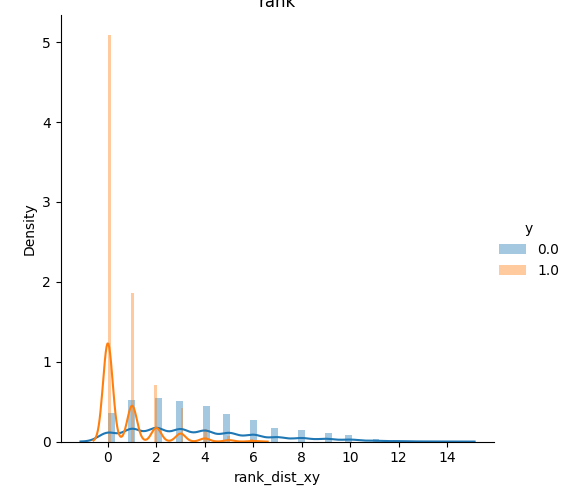

In [100]:
eda('rank_dist_xy',"rank")

<IPython.core.display.Javascript object>


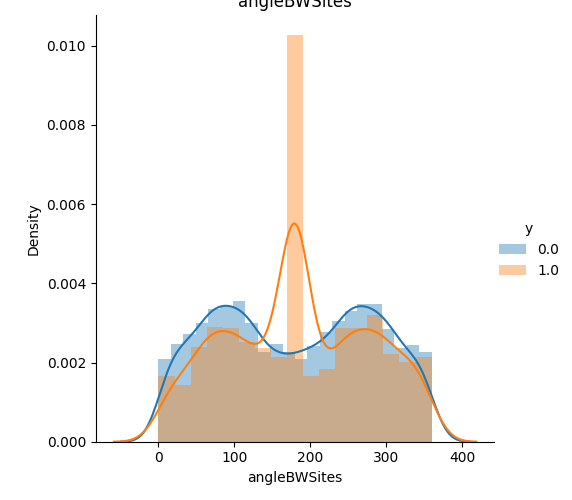

<IPython.core.display.Javascript object>


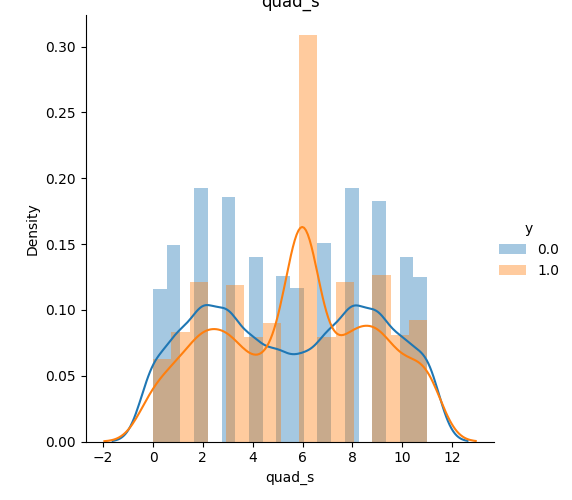

<IPython.core.display.Javascript object>


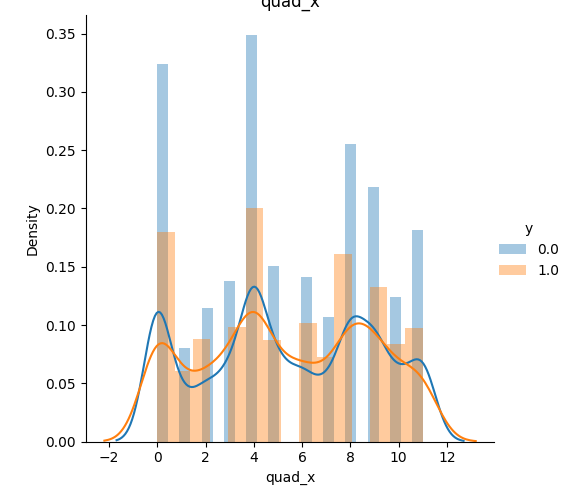

<IPython.core.display.Javascript object>


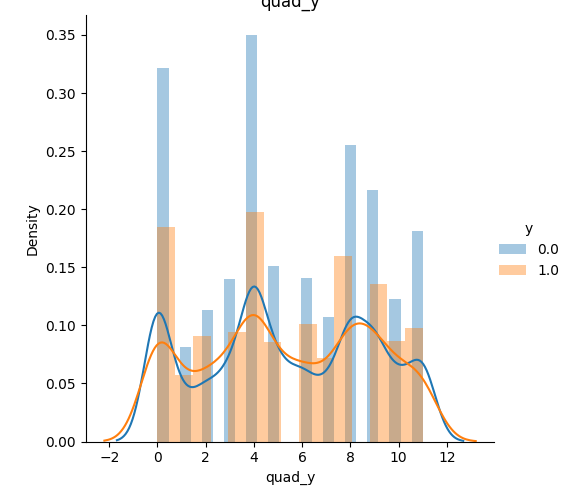

<IPython.core.display.Javascript object>


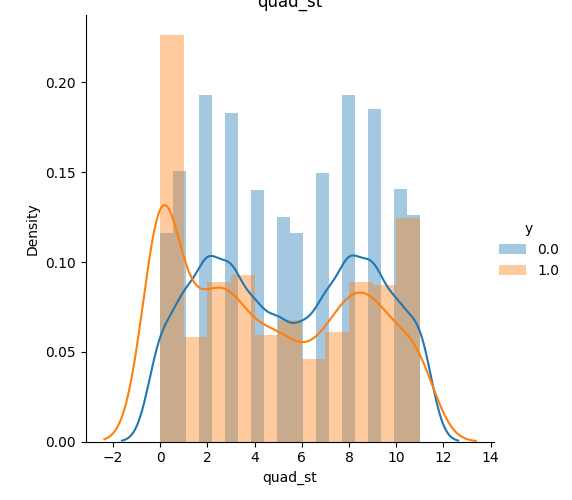

<IPython.core.display.Javascript object>


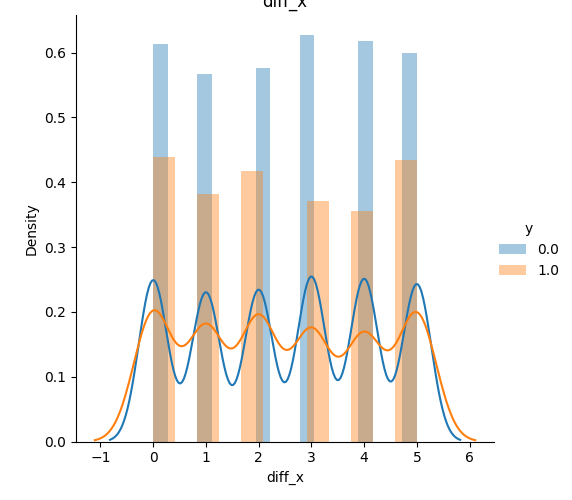

<IPython.core.display.Javascript object>


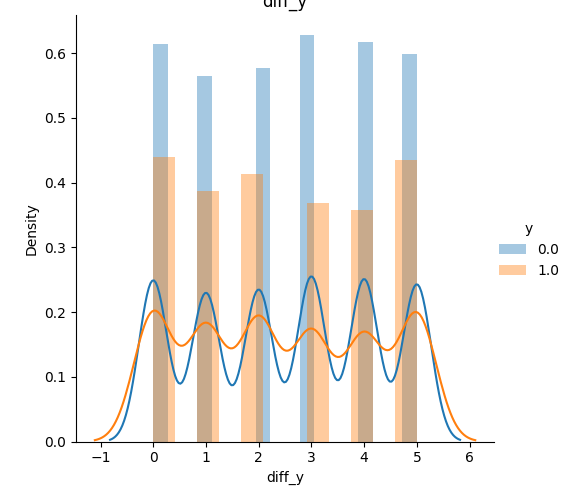

<IPython.core.display.Javascript object>


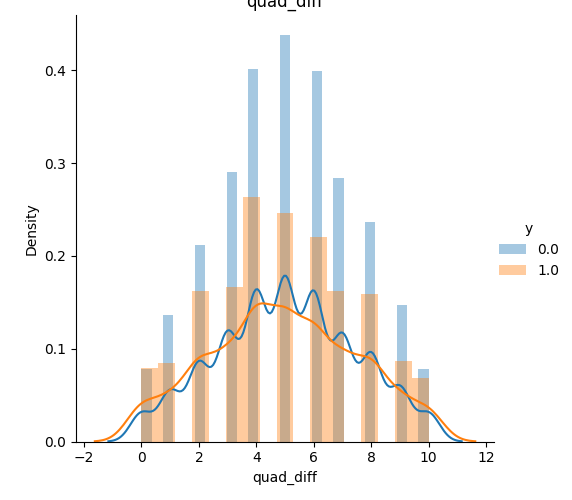

<IPython.core.display.Javascript object>


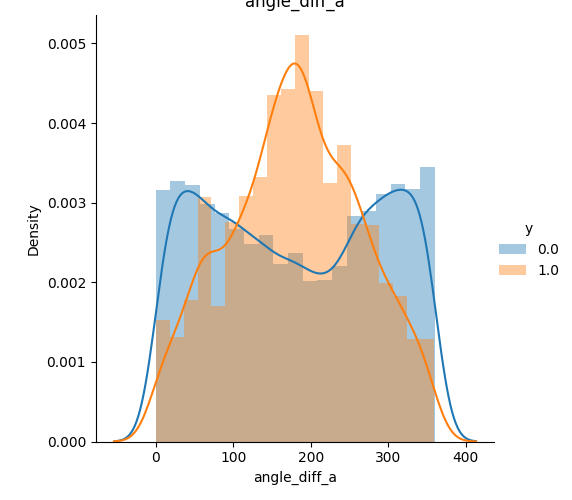

<IPython.core.display.Javascript object>


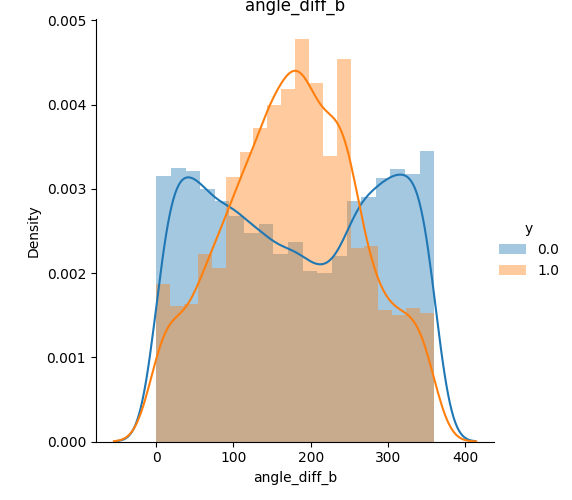

<IPython.core.display.Javascript object>


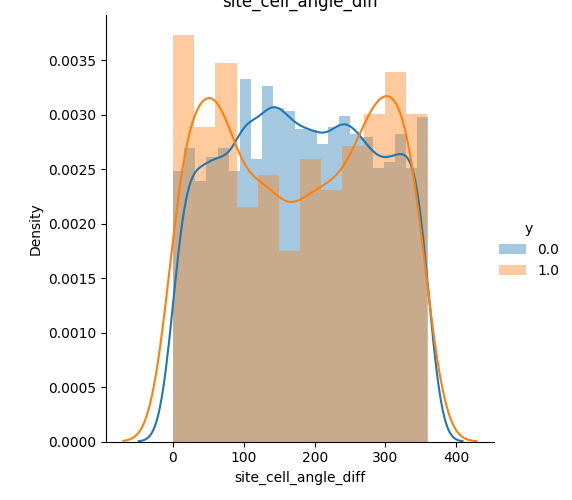

<IPython.core.display.Javascript object>


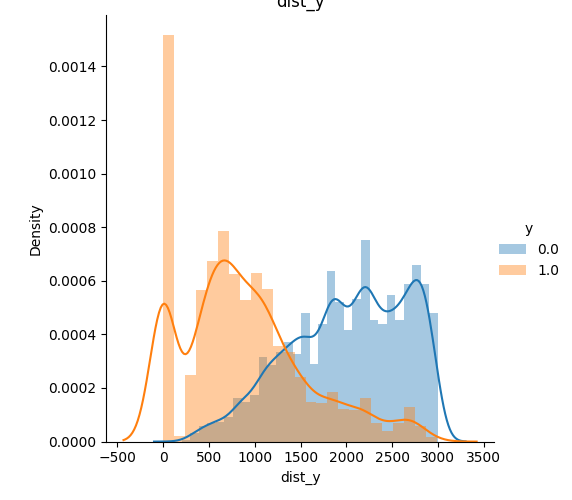

<IPython.core.display.Javascript object>


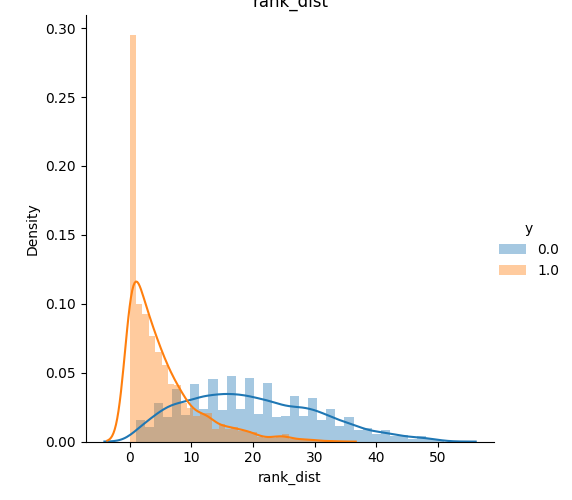

<IPython.core.display.Javascript object>


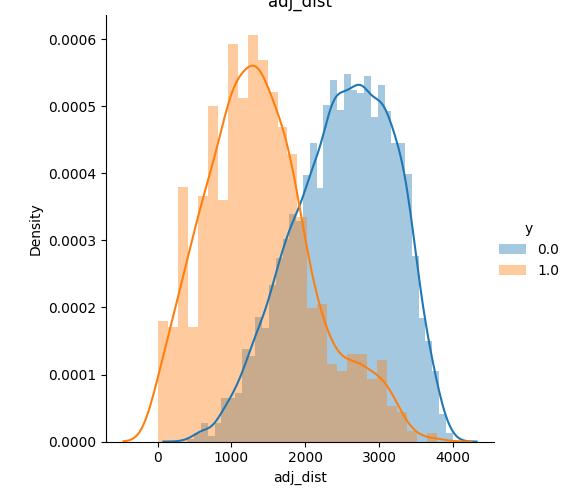

<IPython.core.display.Javascript object>


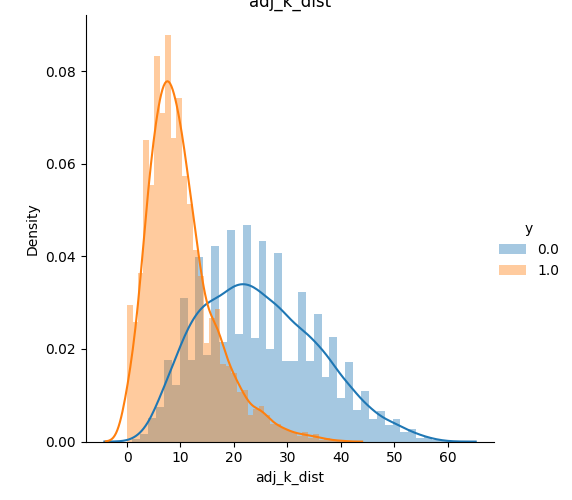

<IPython.core.display.Javascript object>


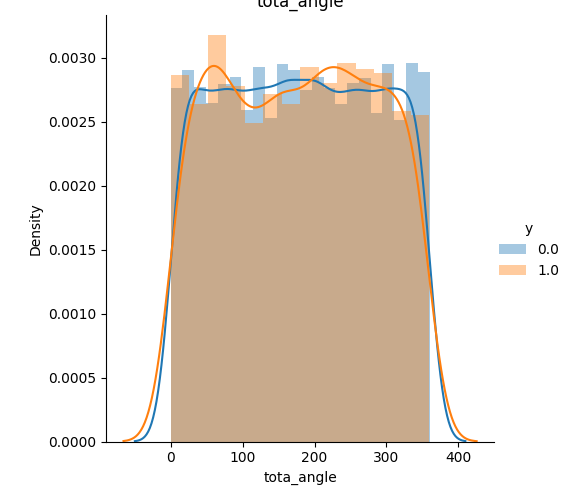

In [97]:
for col in (D_total.columns)[12:]:
    eda(col,col)

<IPython.core.display.Javascript object>


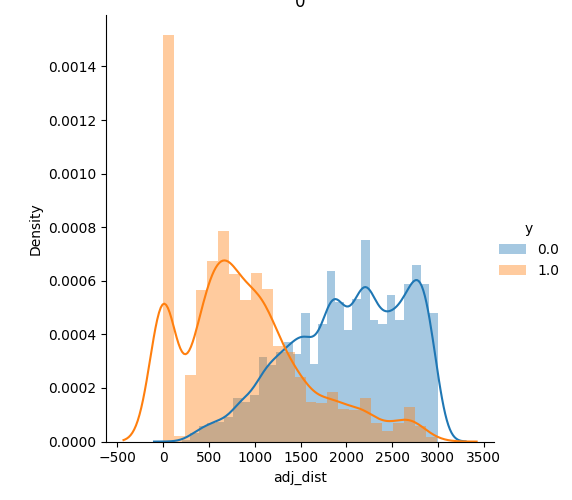

<IPython.core.display.Javascript object>


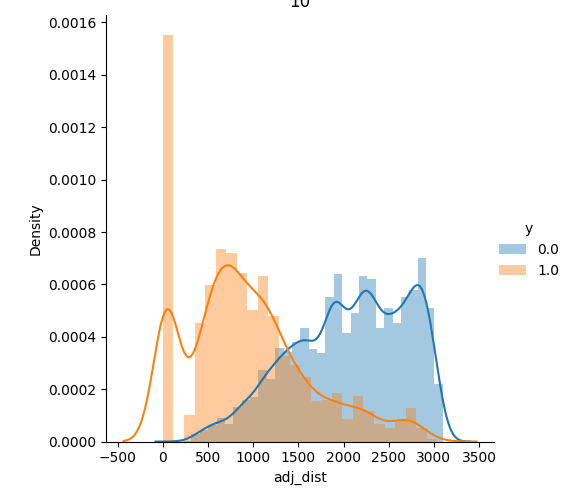

<IPython.core.display.Javascript object>


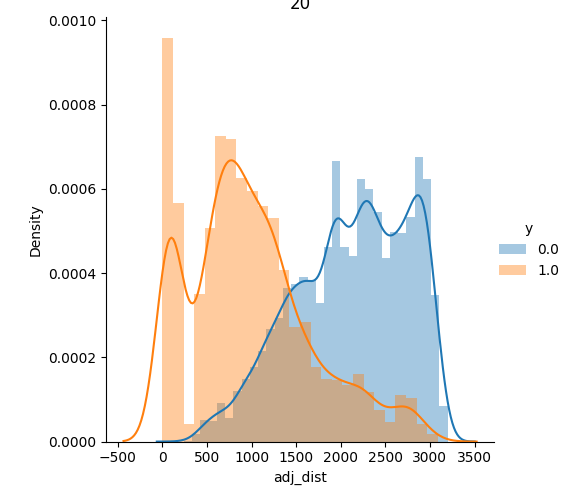

<IPython.core.display.Javascript object>


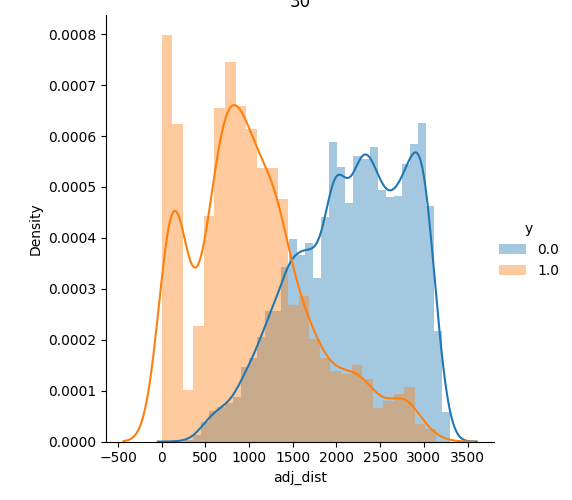

<IPython.core.display.Javascript object>


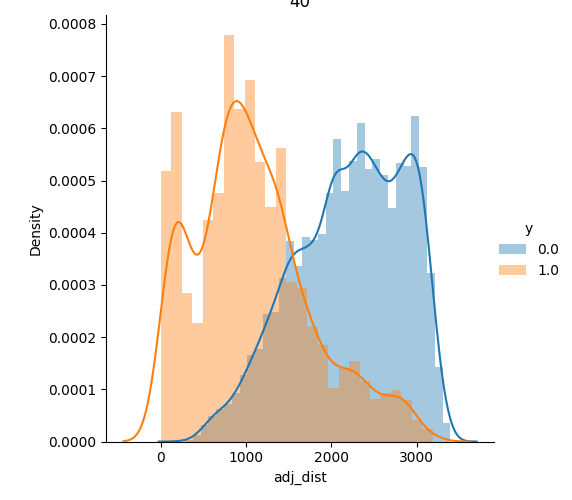

<IPython.core.display.Javascript object>


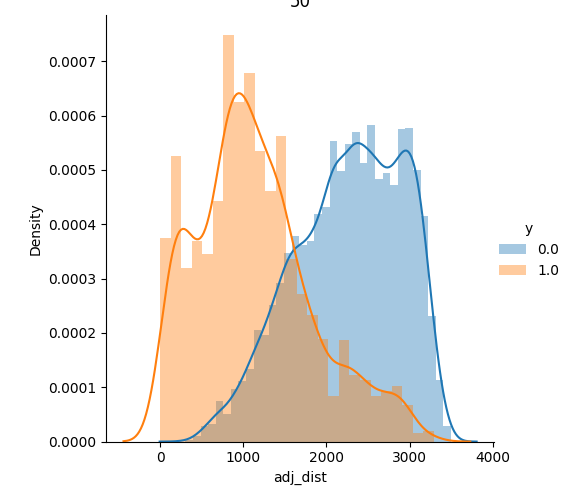

<IPython.core.display.Javascript object>


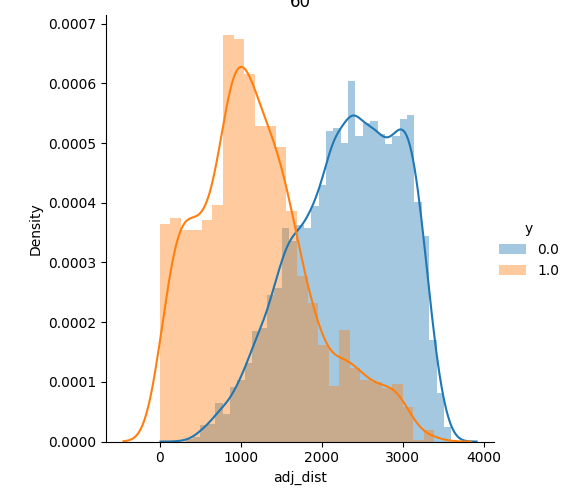

<IPython.core.display.Javascript object>


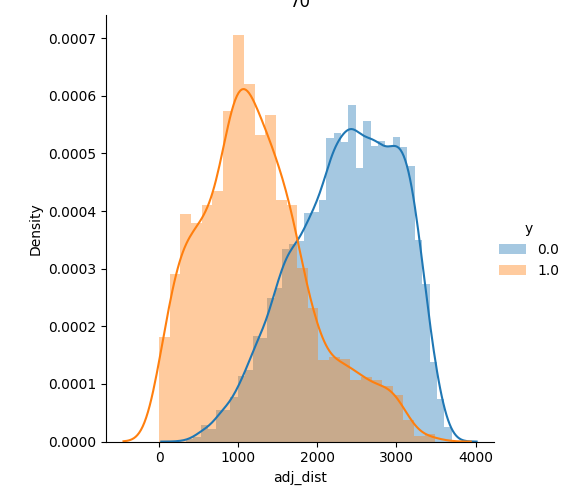

<IPython.core.display.Javascript object>


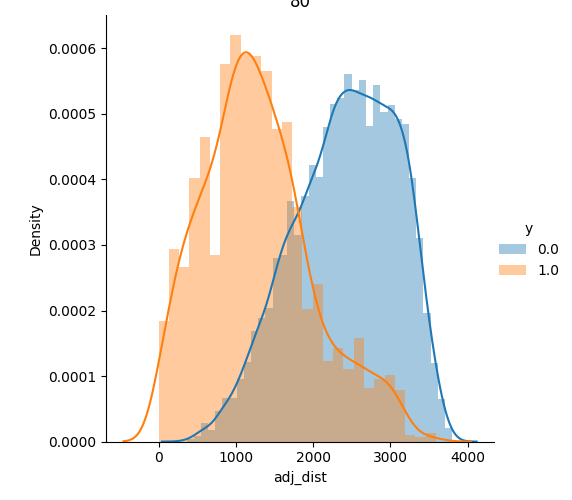

<IPython.core.display.Javascript object>


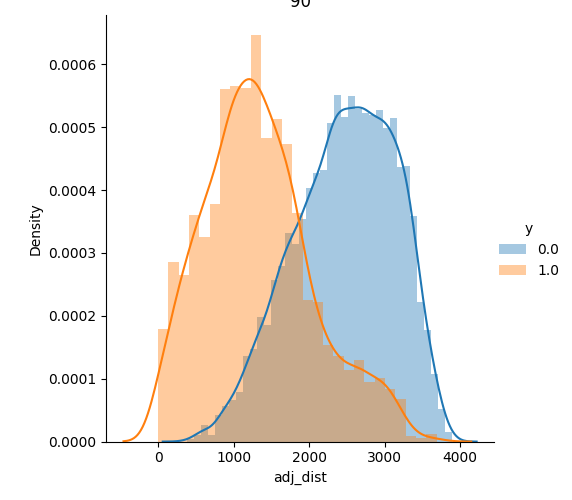

<IPython.core.display.Javascript object>


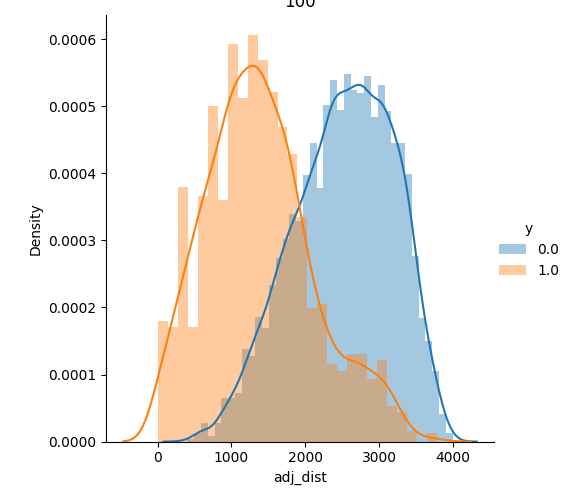

<IPython.core.display.Javascript object>


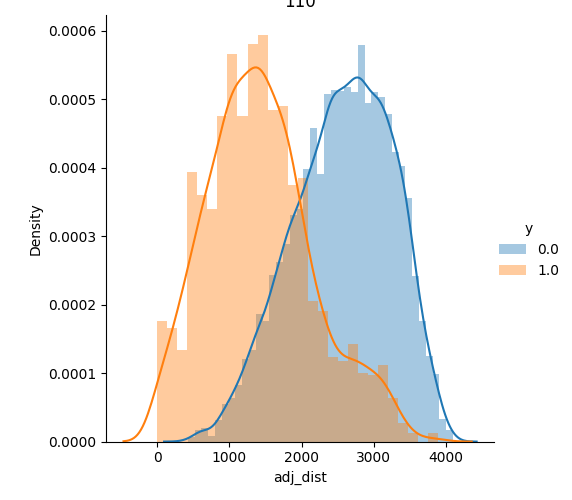

<IPython.core.display.Javascript object>


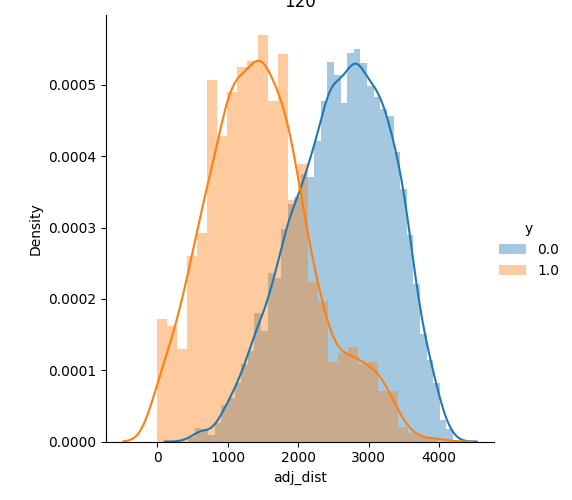

<IPython.core.display.Javascript object>


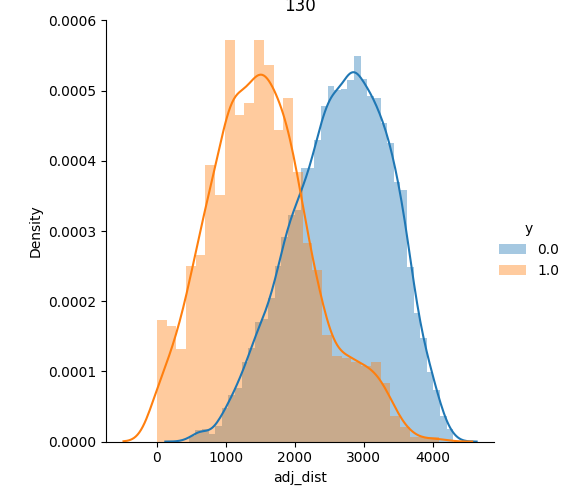

<IPython.core.display.Javascript object>


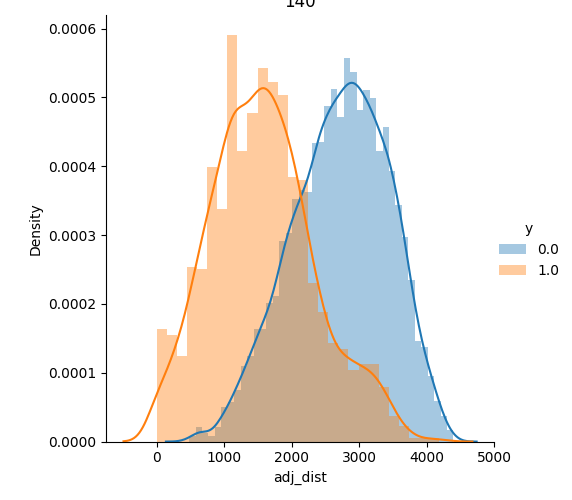

<IPython.core.display.Javascript object>


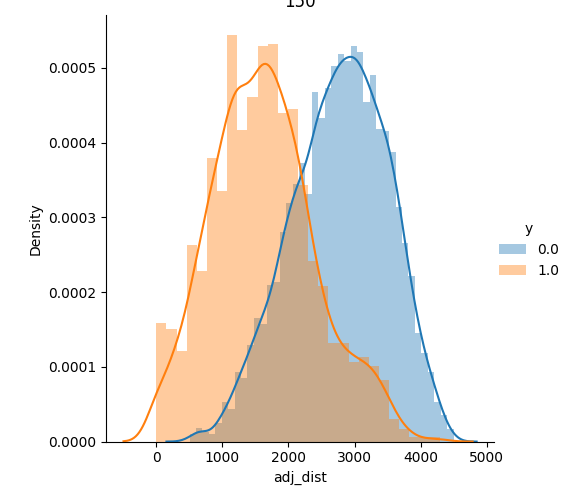

<IPython.core.display.Javascript object>


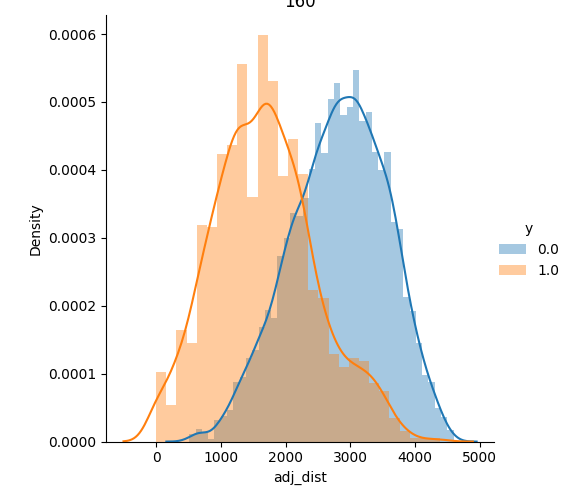

<IPython.core.display.Javascript object>


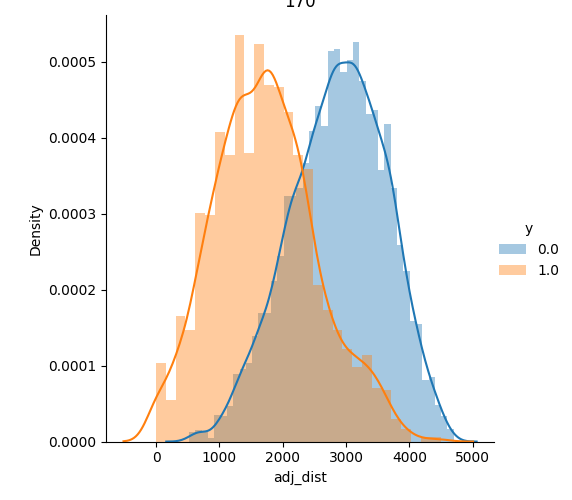

<IPython.core.display.Javascript object>


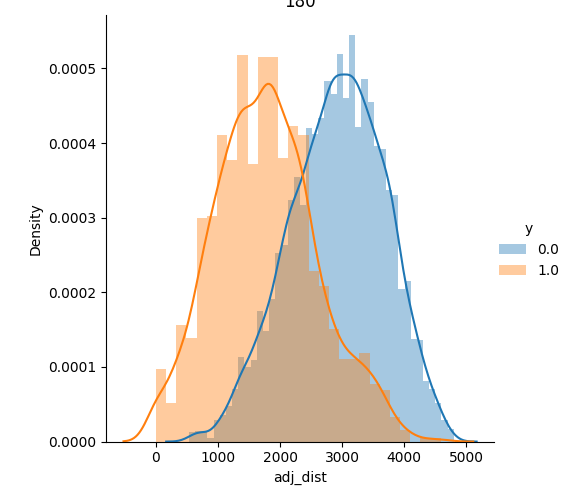

<IPython.core.display.Javascript object>


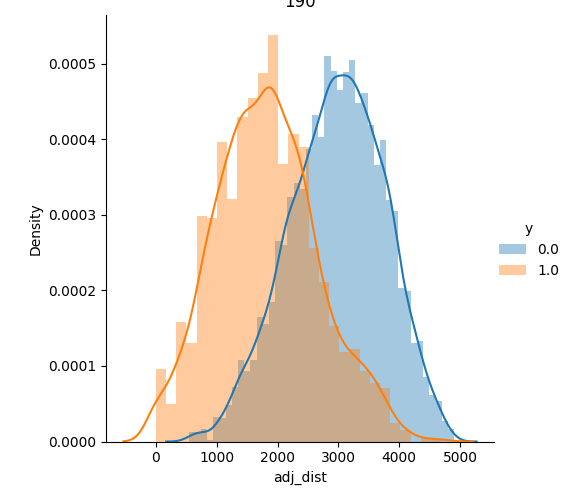

In [81]:
for i in range (0,200,10):
    D_total['adj_dist']=D_total['dist_x']+i*(D_total['diff_x']+D_total['diff_y'])
    eda('adj_dist',i)